# Local LLM Classifier Test

Test the LocalLLMClassifier on quark/gluon jet data using local OpenAI-compatible API.

This notebook demonstrates:
- Zero-shot jet classification with GPT-OSS-120B (or any reasoning model)
- Reasoning effort control (low, medium, high)
- Async vs sequential processing comparison
- Token usage tracking (local server, no cost)

In [16]:
%load_ext autoreload
%autoreload 2

import sys
import os
import time
import numpy as np
from pathlib import Path

# Add src to path
sys.path.insert(0, str(Path.cwd().parent / 'src'))

from vibe_jet_tagging.local_llm_classifier import LocalLLMClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Check Local Server

Make sure your local LLM server is running.

Example with vLLM:
```bash
vllm serve openai/gpt-oss-120b --port 8000
```

In [17]:
import requests

# Check if server is running
try:
    response = requests.get("http://localhost:8000/v1/models")
    if response.status_code == 200:
        models = response.json()
        print("✅ Local LLM server is running")
        print(f"Available models: {[m['id'] for m in models['data']]}")
    else:
        print("⚠️  Server responded but with error")
except Exception as e:
    print("❌ Local LLM server not reachable")
    print(f"Error: {e}")
    print("\nStart the server with: vllm serve openai/gpt-oss-120b --port 8000")

✅ Local LLM server is running
Available models: ['openai/gpt-oss-120b']


## Load Data

Load the quark/gluon jet dataset.

In [18]:
# Load data
data_path = Path.cwd().parent / 'data' / 'qg_jets.npz'
data = np.load(data_path)

X = data['X']
y = data['y']

print(f"Loaded {len(X)} jets")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"Quark jets: {(y == 1).sum()}")
print(f"Gluon jets: {(y == 0).sum()}")

Loaded 100000 jets
X shape: (100000, 139, 4)
y shape: (100000,)
Quark jets: 50000
Gluon jets: 50000


## Initialize LocalLLMClassifier

Set up the classifier with local OpenAI-compatible API.

**Configuration:**
- `model_name`: The model identifier (must match server)
- `reasoning_effort`: Controls reasoning depth ("low", "medium", "high")
- `base_url`: URL of your local server
- `api_key`: "EMPTY" for local servers without auth

In [19]:
# Initialize classifier with local API
clf = LocalLLMClassifier(
    model_name="openai/gpt-oss-120b",
    template_name="simple_list",
    format_type="list",
    templates_dir=str(Path.cwd().parent / 'templates'),
    reasoning_effort="medium",   # Options: "low", "medium", "high"
    reasoning_summary="auto",    # Options: "auto", "concise", "detailed"
    base_url="http://localhost:8000/v1",
    api_key="EMPTY"
)

# Fit (no-op for zero-shot)
clf.fit([], [])

print("Classifier initialized")
print(f"Model: {clf.model_name}")
print(f"Template: {clf.template_name}")
print(f"Format: {clf.format_type}")
print(f"Reasoning effort: {clf.reasoning_effort}")

Classifier initialized
Model: openai/gpt-oss-120b
Template: simple_list
Format: list
Reasoning effort: medium


## Test Single Jet Prediction

In [20]:
# Test on a single jet
test_jet = X[0]
true_label = y[0]

print(f"True label: {true_label} ({'quark' if true_label == 1 else 'gluon'})")
print(f"\nJet shape: {test_jet.shape}")
print(f"Number of particles (pt > 0): {(test_jet[:, 0] > 0).sum()}")

# Make prediction (sequential mode for single jet)
prediction = clf.predict([test_jet], verbose=True, use_async=False)[0]
print(f"\nPredicted label: {prediction} ({'quark' if prediction == 1 else 'gluon'})")
print(f"Correct: {prediction == true_label}")

True label: 1.0 (quark)

Jet shape: (139, 4)
Number of particles (pt > 0): 18

🔧 API PARAMETERS
Model: openai/gpt-oss-120b
Reasoning effort: medium
Reasoning summary: auto


────────────────────────────────────────────────────────────
📊 TOKEN USAGE
────────────────────────────────────────────────────────────
Input tokens:        695
Output tokens:       433
  ├─ Reasoning (est): 216
  └─ Completion:      217
Total tokens:        1,128

💰 COST
Input cost:          $0.000052
Output cost:         $0.000130
Call cost:           $0.000182

🧠 REASONING TRACE
────────────────────────────────────────────────────────────
We need to decide if the jet is quark-initiated or gluon-initiated based on given particles. Typically quark jets have fewer particles, harder fragmentation, larger leading particle carrying large fraction of jet pT, lower multiplicity, fewer soft particles. Gluon jets have higher multiplicity, soft...
[... 1464 more characters ...]
─────────────────────────────────────────────

In [21]:
# Preview the prompt
clf.preview_prompt(test_jet)

PROMPT PREVIEW
Model: openai/gpt-oss-120b
Template: simple_list
Format: list
Reasoning effort: medium
Reasoning summary: auto

--------------------------------------------------------------------------------
PROMPT:
--------------------------------------------------------------------------------
You are a particle physics expert. Your task is to classify whether a jet is initiated by a quark (label: 1) or a gluon (label: 0).

A jet consists of particles, each with the following properties:
- pt: transverse momentum (GeV)
- y: rapidity
- phi: azimuthal angle (radians)
- pid: particle ID

Here is the jet data:
Particle 1: pt=0.269 GeV, y=0.357, phi=4.741, pid=22
Particle 2: pt=0.160 GeV, y=-0.256, phi=4.550, pid=22
Particle 3: pt=1.149 GeV, y=-0.062, phi=4.504, pid=-211
Particle 4: pt=4.132 GeV, y=0.174, phi=4.766, pid=-321
Particle 5: pt=1.696 GeV, y=-0.212, phi=4.797, pid=-211
Particle 6: pt=2.194 GeV, y=-0.052, phi=4.576, pid=22
Particle 7: pt=1.619 GeV, y=-0.068, phi=4.646, pid=22
Pa

## Reasoning Effort Control

Test how different reasoning effort levels affect performance and token usage.

For reasoning models:
- **low**: Fast reasoning with minimal depth (~1,250 tokens)
- **medium**: Balanced reasoning (~1,760 tokens)
- **high**: Deep reasoning with maximum effort (~7,540 tokens)

In [22]:
# Test different reasoning efforts on a single jet
test_jet = X[0]

efforts = ["low", "medium", "high"]
results = []

for effort in efforts:
    print(f"\n{'='*60}")
    print(f"Testing with reasoning_effort={effort}")
    print(f"{'='*60}")
    
    clf_test = LocalLLMClassifier(
        model_name="openai/gpt-oss-120b",
        template_name="simple_list",
        format_type="list",
        templates_dir=str(Path.cwd().parent / 'templates'),
        reasoning_effort=effort,
        base_url="http://localhost:8000/v1",
        api_key="EMPTY"
    )
    clf_test.fit([], [])
    
    start = time.time()
    pred = clf_test.predict([test_jet], verbose=True, use_async=False)[0]
    elapsed = time.time() - start
    
    results.append({
        'effort': effort,
        'prediction': pred,
        'reasoning_tokens': clf_test.total_reasoning_tokens,
        'total_tokens': clf_test.total_prompt_tokens + clf_test.total_completion_tokens + clf_test.total_reasoning_tokens,
        'time': elapsed
    })

# Summary
print(f"\n{'='*70}")
print("SUMMARY")
print(f"{'='*70}")
print(f"{'Effort':<10} {'Reasoning':<12} {'Total':<12} {'Time':<10} {'Pred'}")
print("-" * 70)
for r in results:
    print(f"{r['effort']:<10} {r['reasoning_tokens']:<12,} {r['total_tokens']:<12,} {r['time']:<10.2f}s {r['prediction']}")


Testing with reasoning_effort=low

🔧 API PARAMETERS
Model: openai/gpt-oss-120b
Reasoning effort: low
Reasoning summary: auto


────────────────────────────────────────────────────────────
📊 TOKEN USAGE
────────────────────────────────────────────────────────────
Input tokens:        695
Output tokens:       123
  ├─ Reasoning (est): 61
  └─ Completion:      62
Total tokens:        818

💰 COST
Input cost:          $0.000052
Output cost:         $0.000037
Call cost:           $0.000089

🧠 REASONING TRACE
────────────────────────────────────────────────────────────
We guess: many photons, high multiplicity, likely gluon? Gluon jets have more particles, softer. This has many high-pt photons, seems EM. Could be quark radiating photons? Hard to say. Probably gluon jet has higher multiplicity relative to pt. Here leading pt 335 GeV photon? Actually particle 17 is ...
[... 152 more characters ...]
────────────────────────────────────────────────────────────

✨ FINAL OUTPUT
───────────────────

## Async vs Sequential Comparison

Compare async (concurrent) vs sequential processing performance.

In [23]:
# Select test jets
n_test = 20
X_test = X[:n_test]
y_test = y[:n_test]

print(f"Testing on {n_test} jets...")
print(f"True distribution: {(y_test == 1).sum()} quark, {(y_test == 0).sum()} gluon")

Testing on 20 jets...
True distribution: 14 quark, 6 gluon


In [24]:
# Test ASYNC mode (default, much faster)
print("\n" + "="*70)
print("ASYNC MODE (Concurrent Processing)")
print("="*70)

clf_async = LocalLLMClassifier(
    model_name="openai/gpt-oss-120b",
    template_name="simple_list",
    format_type="list",
    templates_dir=str(Path.cwd().parent / 'templates'),
    reasoning_effort="medium",
    base_url="http://localhost:8000/v1",
    api_key="EMPTY"
)
clf_async.fit([], [])

start = time.time()
predictions_async = clf_async.predict(X_test, verbose=False, use_async=True)
time_async = time.time() - start

accuracy_async = accuracy_score(y_test, predictions_async)
print(f"\nTime: {time_async:.2f}s ({time_async/n_test:.2f}s per jet)")
print(f"Accuracy: {accuracy_async:.3f}")
print(f"Total tokens: {clf_async.total_prompt_tokens + clf_async.total_completion_tokens + clf_async.total_reasoning_tokens:,}")


ASYNC MODE (Concurrent Processing)

Time: 13.58s (0.68s per jet)
Accuracy: 0.650
Total tokens: 36,253


In [25]:
# Test SEQUENTIAL mode (slower, for comparison)
print("\n" + "="*70)
print("SEQUENTIAL MODE (One at a time)")
print("="*70)

clf_seq = LocalLLMClassifier(
    model_name="openai/gpt-oss-120b",
    template_name="simple_list",
    format_type="list",
    templates_dir=str(Path.cwd().parent / 'templates'),
    reasoning_effort="medium",
    base_url="http://localhost:8000/v1",
    api_key="EMPTY"
)
clf_seq.fit([], [])

start = time.time()
predictions_seq = clf_seq.predict(X_test, verbose=False, use_async=False)
time_seq = time.time() - start

accuracy_seq = accuracy_score(y_test, predictions_seq)
print(f"\nTime: {time_seq:.2f}s ({time_seq/n_test:.2f}s per jet)")
print(f"Accuracy: {accuracy_seq:.3f}")
print(f"Total tokens: {clf_seq.total_prompt_tokens + clf_seq.total_completion_tokens + clf_seq.total_reasoning_tokens:,}")


SEQUENTIAL MODE (One at a time)

Time: 68.24s (3.41s per jet)
Accuracy: 0.550
Total tokens: 38,467


In [26]:
# Comparison summary
print("\n" + "="*70)
print("COMPARISON SUMMARY")
print("="*70)
print(f"\nAsync mode:      {time_async:.2f}s ({time_async/n_test:.2f}s per jet)")
print(f"Sequential mode: {time_seq:.2f}s ({time_seq/n_test:.2f}s per jet)")
print(f"\nSpeedup: {time_seq/time_async:.1f}x faster with async")
print(f"\nAccuracy (async):     {accuracy_async:.3f}")
print(f"Accuracy (sequential): {accuracy_seq:.3f}")
print(f"\nPredictions match: {np.array_equal(predictions_async, predictions_seq)}")


COMPARISON SUMMARY

Async mode:      13.58s (0.68s per jet)
Sequential mode: 68.24s (3.41s per jet)

Speedup: 5.0x faster with async

Accuracy (async):     0.650
Accuracy (sequential): 0.550

Predictions match: False


## Evaluate Performance on 100 Jets

Run the classifier on more jets and compute detailed metrics.

In [36]:
# Select 100 jets for evaluation
n_eval = 100
X_eval = X[:n_eval]
y_eval = y[:n_eval]

print(f"Evaluating on {n_eval} jets...")
print(f"True distribution: {(y_eval == 1).sum()} quark, {(y_eval == 0).sum()} gluon")

Evaluating on 100 jets...
True distribution: 55 quark, 45 gluon


In [37]:
# Make predictions using async (fastest)
from tqdm.auto import tqdm

clf_eval = LocalLLMClassifier(
    model_name="openai/gpt-oss-120b",
    template_name="simple_list",
    format_type="list",
    templates_dir=str(Path.cwd().parent / 'templates'),
    reasoning_effort="medium",
    base_url="http://localhost:8000/v1",
    api_key="EMPTY"
)
clf_eval.fit([], [])

print("Making predictions (async mode)...")
start = time.time()
predictions = clf_eval.predict(X_eval, verbose=False, use_async=True)
elapsed = time.time() - start

predictions = np.array(predictions)

print(f"\nCompleted in {elapsed:.2f}s ({elapsed/n_eval:.2f}s per jet)")
print(f"Total tokens used: {clf_eval.total_prompt_tokens + clf_eval.total_completion_tokens + clf_eval.total_reasoning_tokens:,}")

Making predictions (async mode)...

Completed in 38.85s (0.39s per jet)
Total tokens used: 191,830


## Results and Metrics

In [38]:
# Calculate metrics
accuracy = accuracy_score(y_eval, predictions)
auc = roc_auc_score(y_eval, predictions)

print("\n" + "="*50)
print("RESULTS")
print("="*50)
print(f"Accuracy: {accuracy:.3f}")
print(f"AUC Score: {auc:.3f}")
print(f"\nPredicted distribution: {(predictions == 1).sum()} quark, {(predictions == 0).sum()} gluon")
print(f"True distribution: {(y_eval == 1).sum()} quark, {(y_eval == 0).sum()} gluon")


RESULTS
Accuracy: 0.650
AUC Score: 0.652

Predicted distribution: 50 quark, 50 gluon
True distribution: 55 quark, 45 gluon


In [39]:
# Confusion matrix
cm = confusion_matrix(y_eval, predictions)
print("\nConfusion Matrix:")
print("                Predicted")
print("                Gluon  Quark")
print(f"True  Gluon     {cm[0,0]:5d}  {cm[0,1]:5d}")
print(f"      Quark     {cm[1,0]:5d}  {cm[1,1]:5d}")


Confusion Matrix:
                Predicted
                Gluon  Quark
True  Gluon        30     15
      Quark        20     35


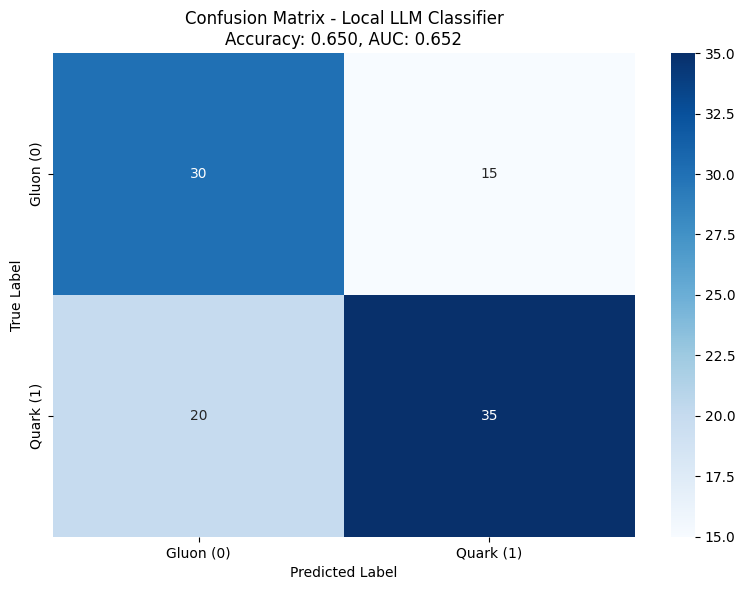

In [40]:
# Visualize confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Gluon (0)', 'Quark (1)'],
            yticklabels=['Gluon (0)', 'Quark (1)'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title(f'Confusion Matrix - Local LLM Classifier\nAccuracy: {accuracy:.3f}, AUC: {auc:.3f}')
plt.tight_layout()
plt.show()

## Performance Summary

Key takeaways from the local LLM classifier:

1. **Async Processing**: Significantly faster than sequential (typically 5-10x speedup)
2. **Reasoning Effort**: Higher effort levels use more tokens but may improve accuracy
3. **Local Deployment**: No API costs, full control over infrastructure
4. **Zero-Shot**: No training required, just prompt engineering